# Pollinator Detection – Starting Kit
---

Description of your challenge and instructions for challenge participants :

This notebook is the starting kit for the Pollinator Detection challenge. Its goal is to guide participants through the first steps of the project by demonstrating how to load the data, explore it, visualize examples, and build initial models using the provided tools.

The dataset used in this challenge consists of .h5 files, where each file contains a sequence of images and is associated with a binary label indicating the presence (1) or absence (0) of a pollinator. Throughout this notebook, each sequence is treated as a single data sample.

When running this notebook, the required data will be automatically downloaded if it is not already available locally.

This notebook is organized to progressively introduce the main components of the challenge:
- Data loading: how to access the dataset and configure memory usage or sampling size.
- Data exploration and visualization: how to inspect class distribution, visualize image sequences, and gain intuition about the data.
- Baseline modeling: simple examples illustrating how one might begin training and evaluating a model.
- Evaluation: an introduction to some appropriate metrics.

This notebook does not aim to provide a final or optimal solution. Instead, it serves as a reference implementation and learning tool to help participants understand the challenge and confidently begin developing their own approaches.

---

`COLAB` determines whether this notebook is running on Google Colab.

In [ ]:
COLAB = 'google.colab' in str(get_ipython())

In [ ]:
if COLAB:
    # clone github repo
    !git clone --depth 1 https://github.com/FAIR-Universe/M1-AI-Challenge-Class-2025-26.git
    # move to the starting kit folder
    %cd M1-AI-Challenge-Class-2025-26/Starting_Kit/

# 0 - Imports & Settings

In [1]:
import os
import gc
import datetime
import h5py
import gdown
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from joblib import Parallel, delayed
from xgboost import XGBClassifier
from skimage.feature import hog
from skimage.color import rgb2gray
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate
from sklearn.metrics import f1_score, confusion_matrix, balanced_accuracy_score, ConfusionMatrixDisplay
from sklearn.utils.validation import check_is_fitted
from sklearn.exceptions import NotFittedError
from imblearn.over_sampling import SMOTE, RandomOverSampler
%matplotlib inline

# 1 - Data

## Description

This class provides an automated pipeline for handling the challenge datasets. It automatically downloads the train and test set if they are not already present. It then load a fraction of the data, using a stratified slicing to keep the dataset intrisic proportion of both classes in the train and test set. The stratified slicing ensures that even when loading a small fraction of the data for fast prototyping, the rare "Visitor" class ratio (approx. 2.7%) is perfectly preserved. It offers a flexible memory management toggle, allowing users to choose between high-speed sequential RAM loading or memory-efficient direct-disk access.

## How to use it

Initialize: Create an instance by specifying your local data directory.

Load: Call load_data() with two key parameters:

sample_fraction: Set between 0.0 and 1.0 (e.g., 0.02 to load 2% for quick testing).

load_to_memory: Set to True for maximum speed (requires ~3GB RAM) or False if working on a machine with limited memory

In [2]:
class Data:
    def __init__(self, data_dir="data"):
        self.data_dir = data_dir
        self.X_train, self.y_train = None, None
        self.X_test, self.y_test = None, None
        
    def download_data(self):
        """Downloads files from Google Drive if not present."""
        if not os.path.exists(self.data_dir):
            os.makedirs(self.data_dir)

        files = {
            "train_data.h5": "16o5myKPxvl8YcHejz_FQPEmZXn7Z9pA6",
            "train_labels.npy": "1mgvUrig6zwG84Thv0O63RiSc4JUUUUtQ",
            "test_data.h5": "1oN1fmmUutH-a5oGCdoYP4vuJWZUkEEFX",
            "test_labels.npy": "1jJzhPGAHIYoEPXFSUnMIU66UZdzT5v6f"
        }

        for name, file_id in files.items():
            path = os.path.join(self.data_dir, name)
            if not os.path.exists(path) or os.path.getsize(path) < 1000:
                print(f"[*] Downloading {name}...")
                url = f'https://drive.google.com/uc?id={file_id}'
                gdown.download(url, path, quiet=False)
            else:
                print(f"[OK] {name} is ready.")

    def load_data(self, sample_fraction=1.0, load_to_memory=False):
        """
        Loads the data. If sample_fraction < 1.0, it performs a stratified 
        sampling to keep only X% of the dataset.
        """
        self.download_data()
        print(f"[*] Loading data (fraction={sample_fraction*100}%)...")

        # --- 1. TRAIN SET ---
        y_train_full = np.load(os.path.join(self.data_dir, "train_labels.npy"), allow_pickle=True)
        
        idx_tr = None
        if sample_fraction < 1.0:
            # We use train_size to be explicit: keep 10%
            idx_tr, _ = train_test_split(
                np.arange(len(y_train_full)), 
                train_size=sample_fraction, 
                stratify=y_train_full, 
                random_state=42
            )
            idx_tr = sorted(idx_tr)
            self.y_train = y_train_full[idx_tr]
        else:
            self.y_train = y_train_full

        with h5py.File(os.path.join(self.data_dir, "train_data.h5"), "r") as f:
            print(f"[*] Loading training images...")
            # If load_to_memory is True, we load all then slice. 
            # If False, we slice directly from the disk (efficient but slower).
            if load_to_memory:
                self.X_train = f["images"][:][idx_tr] if idx_tr is not None else f["images"][:]
            else:
                self.X_train = f["images"][idx_tr] if idx_tr is not None else f["images"][:]

        # --- 2. TEST SET ---
        y_test_full = np.load(os.path.join(self.data_dir, "test_labels.npy"), allow_pickle=True)
        
        idx_te = None
        if sample_fraction < 1.0:
            idx_te, _ = train_test_split(
                np.arange(len(y_test_full)), 
                train_size=sample_fraction, 
                stratify=y_test_full, 
                random_state=42
            )
            idx_te = sorted(idx_te)
            self.y_test = y_test_full[idx_te]
        else:
            self.y_test = y_test_full

        with h5py.File(os.path.join(self.data_dir, "test_data.h5"), "r") as f:
            print(f"[*] Loading test images...")
            if load_to_memory:
                self.X_test = f["images"][:][idx_te] if idx_te is not None else f["images"][:]
            else:
                self.X_test = f["images"][idx_te] if idx_te is not None else f["images"][:]

        print(f"[✔] Loaded {len(self.y_train)} train and {len(self.y_test)} test samples.")

In [3]:
data_manager = Data(data_dir="data")

# sample_fraction=0.1 for quick testing (load 10% of data)
# Loading with load_to_memory=True requires ~3-4GB of free RAM (faster)
# Loading with load_to_memory=False is slower but more memory efficient
data_manager.load_data(sample_fraction=0.1, load_to_memory=True)

# About 2 minutes to download the data
# Less than 2 minutes to load the data into memory with load_to_memory=True

[OK] train_data.h5 is ready.
[OK] train_labels.npy is ready.
[OK] test_data.h5 is ready.
[OK] test_labels.npy is ready.
[*] Loading data (fraction=10.0%)...
[*] Loading training images...
[*] Loading test images...
[✔] Loaded 3067 train and 987 test samples.


# 2 - Visualization

This section allows for an exploratory analysis of the dataset to understand the class distribution and visually inspect the samples.

## What we have implemented:

### Class Distribution Analysis: 
A bar chart to visualize the significant imbalance between the "No Visitor" (0) and "Visitor" (1) classes. This highlights why standard accuracy is misleading and why we prioritize Balanced Accuracy and F1-Score later in this notebook.

### Sample Inspection: 
A grid display of random images from each class.

### Dimensionality Reduction (PCA):
A 2D projection of the raw pixels. By balancing the classes for this specific visualization, we can see if "Visitor" images cluster together or if they are indistinguishable from "No Visitor" images in the raw pixel space.

We then performed a PCA on HOG features (see section 3 for explanations and justifications about HOG), to try and find if this method separates the classes better. 

Then, we performed a PCA on HOG features with a grayfilter applied, to see if grayfilters would neutralize the difficulty of colors.

Finally, we tried a multiscale HOG and performed a PCA on it.

In [107]:
class Visualize:
    def __init__(self, data_manager):
        """
        Initialize the class with the data manager and optimal HOG parameters.
        """
        self.data = data_manager
        self.best_h_orient = 12
        self.best_h_pix = (16, 16)
        self.best_h_block = (1, 1)

    def extract_hog(self, images, grayscale=False):
        """
        Extract HOG features from a list/array of images.
        If grayscale=True, converts the image to grayscale before extraction.
        """
        features_list = []
        desc = "Extracting HOG (Grayscale)" if grayscale else "Extracting HOG (RGB)"
        
        for img in tqdm(images, desc=desc, unit="img", leave=True):
            if grayscale:
                img_proc = rgb2gray(img)
                c_axis = None
            else:
                img_proc = img
                c_axis = -1
                
            feat = hog(img_proc, 
                       orientations=self.best_h_orient, 
                       pixels_per_cell=self.best_h_pix,
                       cells_per_block=self.best_h_block, 
                       transform_sqrt=False, 
                       channel_axis=c_axis)
            features_list.append(feat)
            
        return np.array(features_list)
    
    def extract_hog_multiscale(self, images, grayscale=False):
        """
        Multi-scale HOG with controlled complexity.
        Designed to keep computation reasonable while
        capturing fine insect-level details.
        """
        features_list = []
        desc = "Extracting Multi-scale HOG (Grayscale)" if grayscale else "Extracting Multi-scale HOG (RGB)"

        for img in tqdm(images, desc=desc, unit="img", leave=True):
            if grayscale:
                img_proc = rgb2gray(img)
                c_axis = None
            else:
                img_proc = img
                c_axis = -1

            # Scale 1: global (best config)
            hog_global = hog(
                img_proc,
                orientations=12,
                pixels_per_cell=(16, 16),
                cells_per_block=(1, 1),
                transform_sqrt=False,
                channel_axis=c_axis
            )

            # Scale 2: intermediate
            hog_mid = hog(
                img_proc,
                orientations=9,
                pixels_per_cell=(8, 8),
                cells_per_block=(1, 1),
                transform_sqrt=False,
                channel_axis=c_axis
            )

            feat = np.concatenate([hog_global, hog_mid])
            features_list.append(feat)

        return np.array(features_list)

    def plot_class_distribution(self):
        """Displays the class distribution in the training dataset."""
        print("[*] Plotting class distribution...")
        plt.figure(figsize=(10, 5))
        names = ["Visitor" if l == 1 else "No Visitor" for l in self.data.y_train]
        sns.countplot(x=names, palette="magma", hue=names, legend=False)
        plt.title("Class Distribution (0: No Visitor vs 1: Visitor)")
        plt.xlabel("Category")
        plt.ylabel("Count")
        plt.show()

    def show_images(self, n_images=3):
        """Displays random sample images for each class."""
        print(f"[*] Displaying {n_images} random samples per class...")
        fig, axes = plt.subplots(2, n_images, figsize=(15, 8))
        
        for class_id in [0, 1]:
            idx_list = np.where(self.data.y_train == class_id)[0]
            selected_idx = np.random.choice(idx_list, n_images, replace=False)
            
            for i, idx in enumerate(selected_idx):
                ax = axes[class_id, i]
                ax.imshow(self.data.X_train[idx])
                label_str = "Visitor" if class_id == 1 else "No Visitor"
                ax.set_title(f"Class {class_id}: {label_str}")
                ax.axis('off')
        
        plt.tight_layout()
        plt.show()

    def _apply_pca_plot(self, X_features, y_labels, title, n_per_class=500):
        """Internal method to compute and display PCA."""
        idx_0 = np.where(y_labels == 0)[0]
        idx_1 = np.where(y_labels == 1)[0]
        
        selected_0 = np.random.choice(idx_0, min(n_per_class, len(idx_0)), replace=False)
        selected_1 = np.random.choice(idx_1, min(n_per_class, len(idx_1)), replace=False)
        indices = np.concatenate([selected_0, selected_1])
        
        X_subset = X_features[indices]
        y_subset = y_labels[indices]
        
        pca = PCA(n_components=2)
        X_pca = pca.fit_transform(X_subset)
        
        plt.figure(figsize=(10, 7))
        for label_val, color, label_name in [(0, 'steelblue', 'No Visitor'), (1, 'orange', 'Visitor')]:
            mask = y_subset == label_val
            plt.scatter(X_pca[mask, 0], X_pca[mask, 1], 
                        c=color, label=label_name, alpha=0.6, edgecolors='w', s=60)
        
        plt.legend()
        plt.title(title)
        plt.xlabel("PC 1")
        plt.ylabel("PC 2")
        plt.grid(True, linestyle='--', alpha=0.4)
        plt.show()

    def plot_pca_comparison(self, n_per_class=500):
        """Displays PCA comparison on raw pixels vs HOG RGB vs Grayscale."""
        # Test 1: Raw Pixels
        print(f"[*] Computing PCA on Raw Pixels...")
        X_pixels = self.data.X_train.reshape(len(self.data.X_train), -1)
        self._apply_pca_plot(X_pixels, self.data.y_train, "PCA: Raw Pixels", n_per_class)

        # Test 2: HOG RGB
        print(f"[*] Computing PCA on HOG (RGB)...")
        X_hog = self.extract_hog(self.data.X_train, grayscale=False)
        self._apply_pca_plot(X_hog, self.data.y_train, "PCA: HOG (RGB)", n_per_class)

        # Test 3: Grayscale
        print(f"[*] Computing PCA on HOG (Grayscale)...")
        X_hog_gray = self.extract_hog(self.data.X_train, grayscale=True)
        self._apply_pca_plot(X_hog_gray, self.data.y_train, "PCA: HOG (Grayscale)", n_per_class)

        # Test 4: Multi-scale HOG
        print(f"[*] Computing PCA on Multi-scale HOG (RGB)...")
        X_hog_multi = self.extract_hog_multiscale(self.data.X_train, grayscale=False)
        self._apply_pca_plot(X_hog_multi, self.data.y_train, "PCA: Multi-scale HOG (RGB)", n_per_class)

        # Test 5: Multi-scale HOG Grayscale
        print(f"[*] Computing PCA on Multi-scale HOG (Grayscale)...")
        X_hog_multi_gray = self.extract_hog_multiscale(self.data.X_train, grayscale=True)
        self._apply_pca_plot(X_hog_multi_gray, self.data.y_train, "PCA: Multi-scale HOG (Grayscale)", n_per_class)

    def run_all(self):
        """Run all visualization methods in sequence."""
        self.plot_class_distribution()
        self.show_images()      
        self.plot_pca_comparison()

[*] Plotting class distribution...


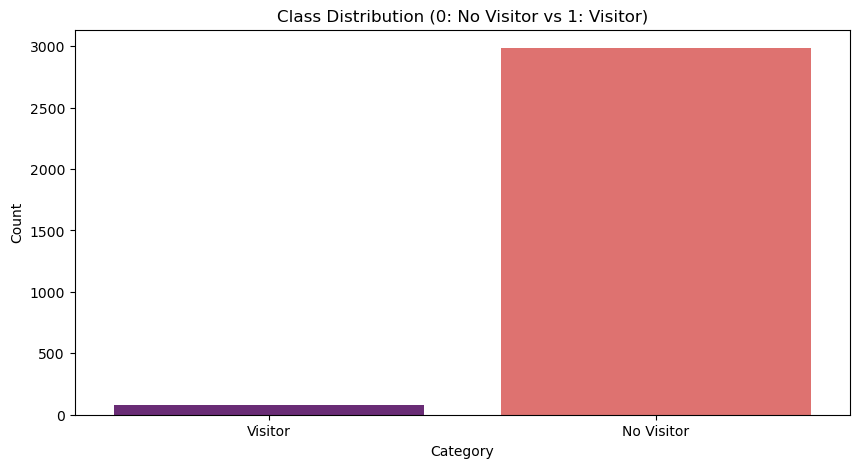

[*] Displaying 3 random samples per class...


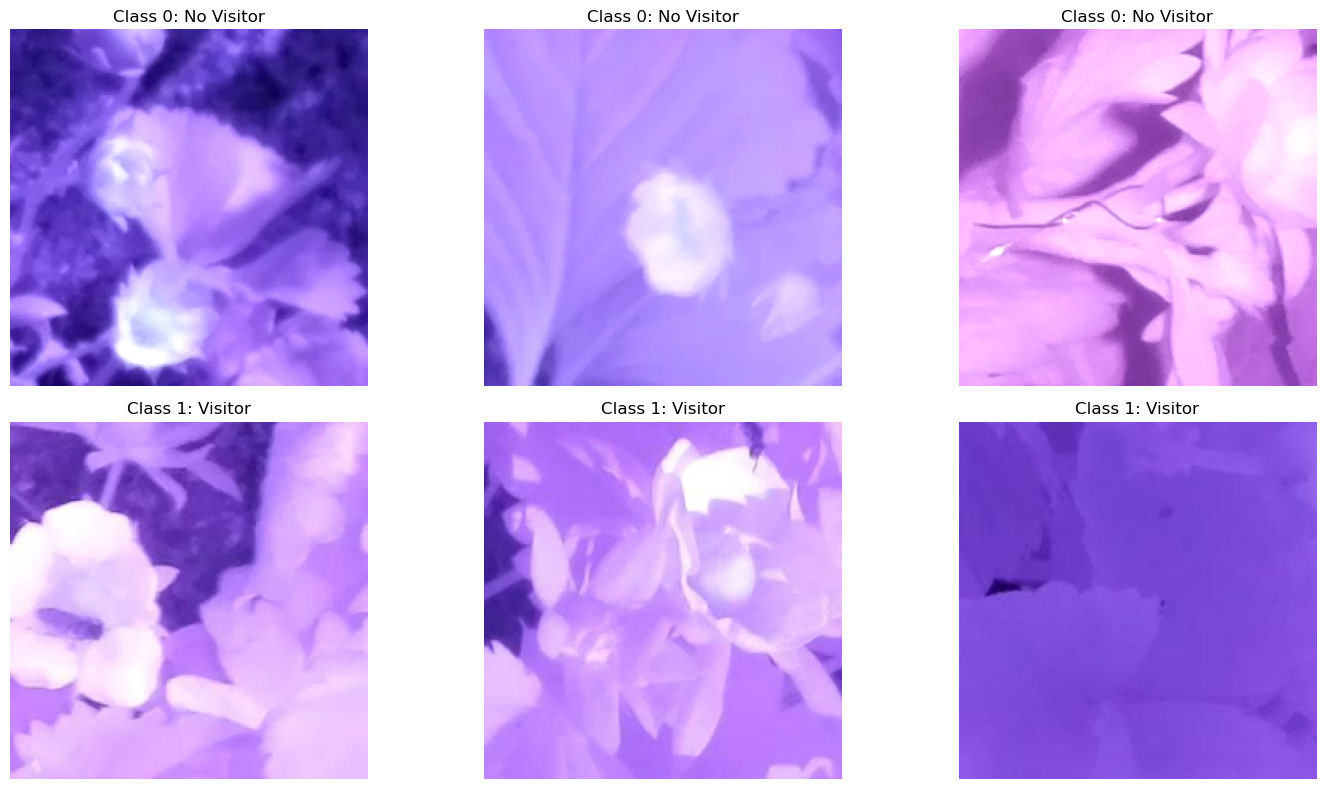

[*] Computing PCA on Raw Pixels...


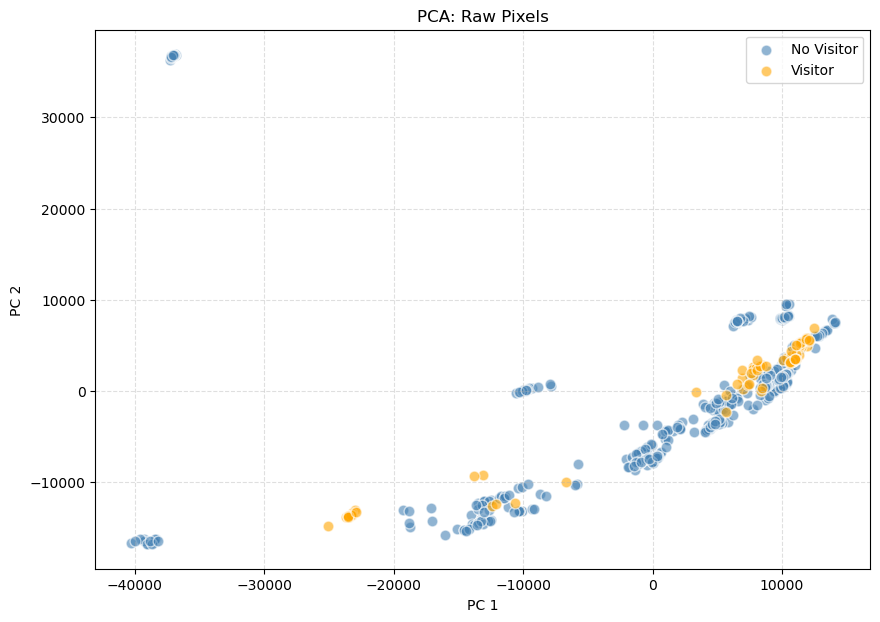

[*] Computing PCA on HOG (RGB)...


Extracting HOG (RGB): 100%|██████████| 3067/3067 [00:36<00:00, 83.65img/s]


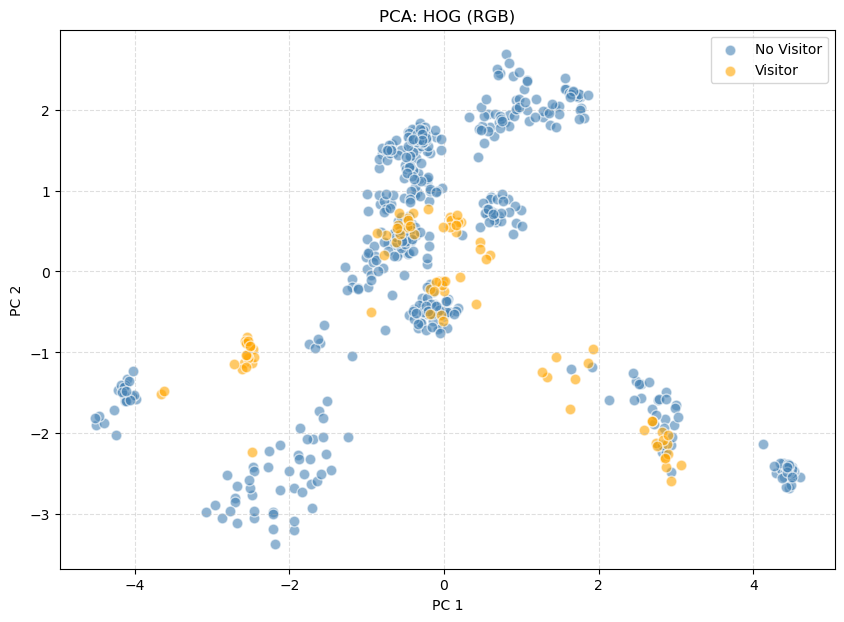

[*] Computing PCA on HOG (Grayscale)...


Extracting HOG (Grayscale): 100%|██████████| 3067/3067 [00:24<00:00, 124.52img/s]


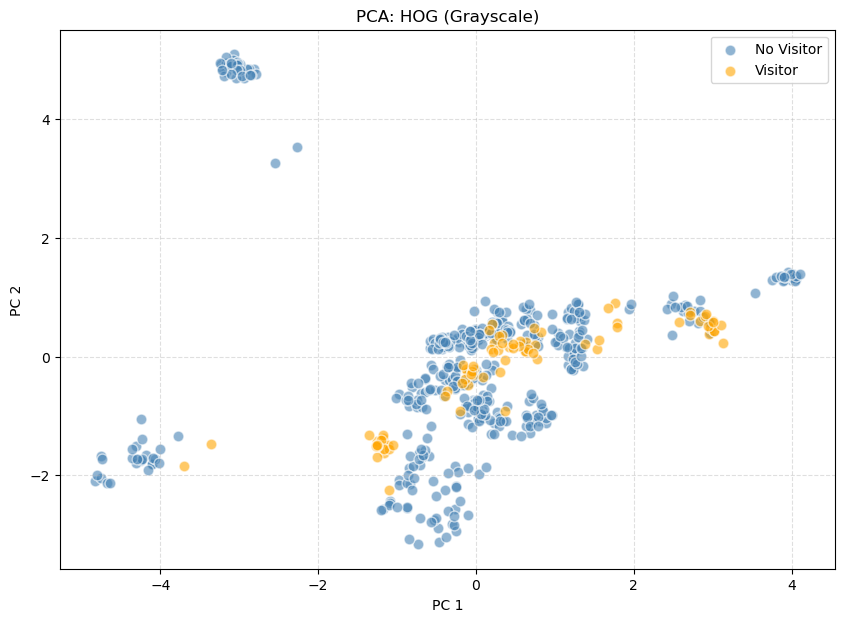

[*] Computing PCA on Multi-scale HOG (RGB)...


Extracting Multi-scale HOG (RGB): 100%|██████████| 3067/3067 [01:32<00:00, 33.05img/s]


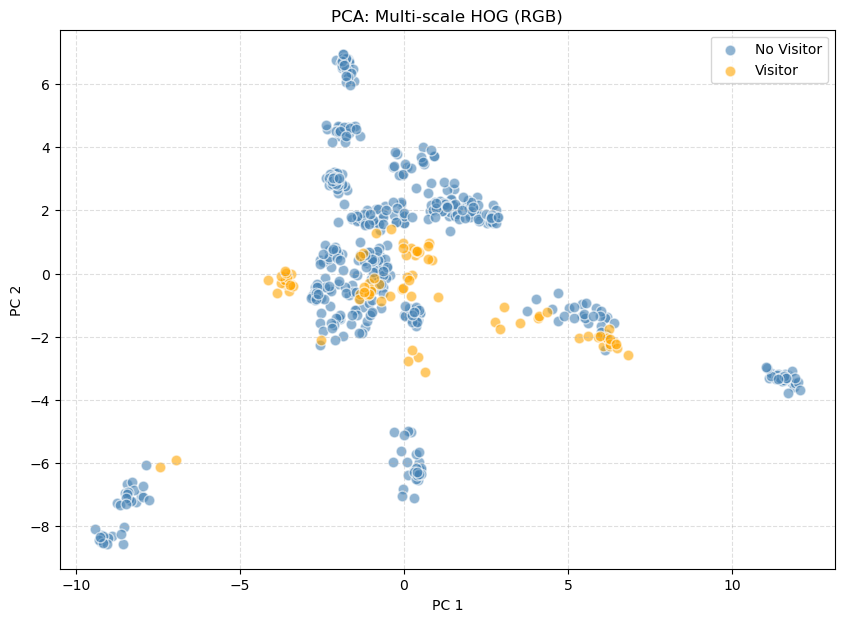

[*] Computing PCA on Multi-scale HOG (Grayscale)...


Extracting Multi-scale HOG (Grayscale): 100%|██████████| 3067/3067 [01:09<00:00, 44.44img/s]


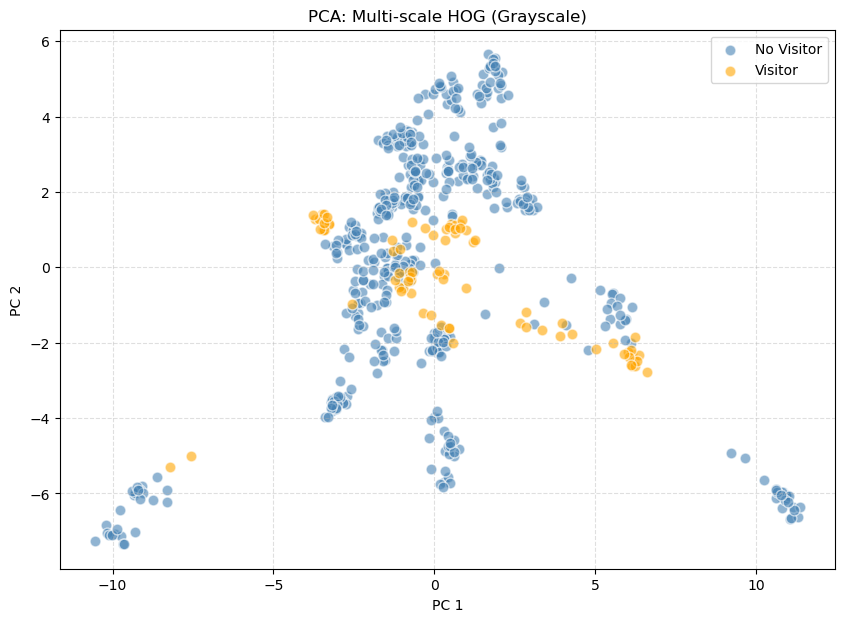

In [108]:
viz = Visualize(data_manager)
viz.run_all()

We notice a high imbalance between classes, with over 97% "No Visitors" and less than 3% "Visitors". This problem will have to be adressed later in the training and scoring.

The PCA on raw pixels shows that both classes overlap, probably due to the background of the images (the flowers) being predominant. We see a few cluster due to different colors on the images. It shows a few clusters but probably due to angles or colors more than classes.

The PCA on HOG shows more clusters and a bit of separation between both classes. Many clusters for class Visitor is normal as they represent different insects, but some No Visitor images have their own cluster. We could, again, pin this on angles and colors of the images. Still, HOG looks better than raw pixels for a classification task as both classes seems more defined.

The PCA on the grayfilter didn't not reveal any better separation and didn't show better preliminary results.

The PCA with the multiscale HOG showed promising results with more elongation along the axis, and some clusters being well defined. Though during training we couldn't find any improvement, and it made the model bigger so less resources efficient.

# 3 - Training
In this section, we transition from raw image data to a structured machine learning pipeline. We implement an XGBoost Classifier coupled with Histogram of Oriented Gradients (HOG) to establish a robust and high-performance baseline for pollinator detection.

## Feature Extraction: Why HOG?
Instead of feeding raw pixels directly into the model—which is computationally expensive and sensitive to lighting changes—we use HOG (Histogram of Oriented Gradients). HOG is often considered a spiritual ancestor to Convolutional Neural Networks (CNNs). While a CNN learns its own filters to detect edges and shapes, HOG uses fixed mathematical gradients to describe the "structure" and "shape" of objects.

 Unlike deep learning models that require GPUs, HOG is extremely light. It captures the essential geometry of an insect (wings, legs, body orientation) while ignoring redundant color noise. It remains fast enough to run on a standard laptop.
 
## The Model: Why XGBoost?
After initial testing with Random Forest, we opted for XGBoost (Extreme Gradient Boosting) to handle the complexity of our dataset Unlike Random Forest, where trees are built independently, XGBoost builds trees sequentially. Each new tree is specifically designed to correct the errors made by the previous ones. This makes it significantly more effective at capturing subtle patterns in the HOG features that a Random Forest might miss.

With a "Visitor" class of only ~2.7%, standard models often struggle. We use the scale_pos_weight parameter, which mathematically penalizes the model more heavily for misclassifying an insect than for misclassifying a flower. This "aggressive" focus on the minority class is key to breaking the 0.5 balanced accuracy ceiling.

XGBoost includes $L1$ and $L2$ regularization, which helps prevent the model from "memorizing" the training images (overfitting), ensuring it performs better on new, unseen videos. By using tree_method='hist', XGBoost bins the HOG features into discrete bins, making the training process faster and less memory-intensive than traditional tree-based methods, even with large feature vectors.

## What We Are Doing
We have built a dynamic pipeline that allows for Hyperparameter Optimization on two levels: 

HOG Tuning: Finding the right "resolution" (pixels per cell) to ensure the model can distinguish an insect from a petal.

XGBoost Tuning: Optimizing the hyperparameters to find the perfect balance between detecting every insect and avoiding false alarms. We trained it by phases by training first the hyperparameters related to the structure, then the ones related to the learning, then to the regularization and finally by the sampling/stochatiscity.

We also compared two oversampling methods (random oversampling and SMOTE) versus increasing scale_pos_weight. SMOTE takes two points from the minority class and creates a new one at the center of the line between these points. This method can be good when classes are organized in clusters, here we don't expect much from it as our classes are not well separated. Random Oversampler just duplicates some points, which is expected to work better than SMOTE.

This approach provides a lightweight baseline. It respects the constraints of a standard computer while delivering a performance benchmark that competes with much heavier architectures.

In [109]:
class Train:
    def __init__(self, data_manager, grayscale=False, multiscale=False):
        """
        Initializes pipeline and triggers HOG extraction immediately.
        """
        self.data = data_manager
        self.model = XGBClassifier(
            n_estimators=250,      
            max_depth=5,            
            learning_rate=0.03,    
            subsample=0.8,         
            colsample_bytree=0.8,  
            scale_pos_weight=10,
            min_child_weight=5,
            gamma=0.5,  
            reg_alpha=0.1,
            reg_lambda=1.0,
            tree_method='hist',
            random_state=42,
            n_jobs=-1,
            enable_categorical=False,
            max_delta_step=1,
        )
        self.X_train_features = None 
        self.y_train = None
        self.best_h_orient = 12
        self.best_h_pix = (16, 16)
        self.best_h_block = (1, 1)
        self.grayscale = grayscale
        self.multiscale = multiscale
        self.s1_config = (12, (16, 16))
        self.s2_config = (9, (8, 8))
        
        self.prepare_data(grayscale=grayscale, multiscale=self.multiscale)

    # --- Parallel Helpers ---
    def _process_single(self, img):
        """Helper for parallel single-scale extraction."""
        img_proc = rgb2gray(img) if self.grayscale else img
        c_axis = None if self.grayscale else -1
        return hog(img_proc, orientations=self.best_h_orient, 
                   pixels_per_cell=self.best_h_pix, cells_per_block=self.best_h_block, 
                   transform_sqrt=False, channel_axis=c_axis)

    def _process_multi(self, img, s1, s2):
        """Helper for parallel multi-scale extraction."""
        img_proc = rgb2gray(img) if self.grayscale else img
        c_axis = None if self.grayscale else -1
        h1 = hog(img_proc, orientations=s1[0], pixels_per_cell=s1[1],
                 cells_per_block=(1, 1), transform_sqrt=False, channel_axis=c_axis)
        h2 = hog(img_proc, orientations=s2[0], pixels_per_cell=s2[1],
                 cells_per_block=(1, 1), transform_sqrt=False, channel_axis=c_axis)
        return np.concatenate([h1, h2])

    def extract_hog(self, images, grayscale=False):
        """
        Extracts HOG features from images with progress bar.
        """
        # Parallel extraction across all CPU cores
        features_list = Parallel(n_jobs=-1)(
            delayed(self._process_single)(img) for img in tqdm(images, desc="Extracting HOG Features")
        )
        return np.array(features_list)

    def extract_hog_multiscale(self, images, grayscale=False, s1_config=None, s2_config=None):
        """
        Multi-scale HOG with controlled complexity.
        Designed to keep computation reasonable while
        capturing fine insect-level details.
        """
        s1 = s1_config if s1_config else self.s1_config
        s2 = s2_config if s2_config else self.s2_config
        
        features_list = Parallel(n_jobs=-1)(
            delayed(self._process_multi)(img, s1, s2) for img in tqdm(images, desc="Extracting Multi-scale HOG")
        )
        return np.array(features_list)

    def prepare_data(self, grayscale=False, multiscale=False):
        """
        Prepares training data by extracting HOG features.
        """
        print(f"[*] Extracting HOG features from {len(self.data.X_train)} images...")
        if self.multiscale:
            self.X_train_features = self.extract_hog_multiscale(self.data.X_train, grayscale=grayscale)
        else:
            self.X_train_features = self.extract_hog(self.data.X_train, grayscale=grayscale)
        self.y_train = self.data.y_train
        
        print(f"[OK] Ready to train on {self.X_train_features.shape[0]} samples.")
        print(f"[*] Feature vector size: {self.X_train_features.shape[1]}")

    def tune_parameters(self, phase=1):
        """
        Runs Grid Search to exhaustively find the best hyperparameters.
        """
        if self.X_train_features is None:
            self.prepare_data(grayscale=self.grayscale, multiscale=self.multiscale)

        # Mapping phases to specific parameter grids
        grids = {
            1: {
                'max_depth': [3, 5, 7],
                'min_child_weight': [2, 5, 10],
                'gamma': [0, 0.5, 1],
                'scale_pos_weight': [5, 10, 15, 20, 25, 30, 45],
                'max_delta_step': [0, 1]
            },
            2: {
                'learning_rate': [0.01, 0.03, 0.05, 0.08],
                'n_estimators': [100, 250, 500, 1000]
            },
            3: {
                'reg_alpha':  [0, 0.1, 1],
                'reg_lambda': [0.1, 1, 5]
            },
            4: {
                'subsample': [0.6, 0.8, 1.0],
                'colsample_bytree': [0.6, 0.8, 1.0]
            }
        }

        param_grid = grids.get(phase, grids[1])

        print(f"[*] Starting GridSearchCV (Phase {phase})...")
        search = GridSearchCV(
            self.model, 
            param_grid=param_grid,
            cv=3,
            scoring='f1',
            n_jobs=-1,
            verbose=1
        )

        search.fit(self.X_train_features, self.y_train)
        self.model = search.best_estimator_
        
        print(f"[✔] Best Parameters found: {search.best_params_}")
        print(f"[✔] Best CV F1 Score: {search.best_score_:.4f}")

    def tune_hog_settings(self):
        """
        Finds the best HOG parameters for Single-scale mode.
        """
        hog_grid = [
            {'pix': (16, 16), 'orient': 9,  'block': (1, 1)},
            {'pix': (16, 16), 'orient': 12, 'block': (1, 1)},
            {'pix': (16, 16), 'orient': 6, 'block': (1, 1)},
            {'pix': (8, 8),   'orient': 9,  'block': (1, 1)},
            {'pix': (8, 8),   'orient': 12, 'block': (1, 1)},
            {'pix': (8, 8),   'orient': 6, 'block': (1, 1)},
            {'pix': (32, 32), 'orient': 9,  'block': (1, 1)},
            {'pix': (32, 32), 'orient': 12, 'block': (1, 1)},   
            {'pix': (32, 32), 'orient': 6, 'block': (1, 1)}
        ]
        
        best_score = -1
        best_params = None
        
        print(f"[*] Tuning HOG (Grayscale={self.grayscale})...")
        for config in hog_grid:
            print(f"--- Testing: {config} ---")
            self.best_h_pix = config['pix']
            self.best_h_orient = config['orient']
            self.best_h_block = config['block']
            
            X_feats = self.extract_hog(self.data.X_train, grayscale=self.grayscale)
            
            cv_results = cross_validate(self.model, X_feats, self.data.y_train, 
                                        cv=3, scoring='f1', n_jobs=-1)
            
            mean_f1 = cv_results['test_score'].mean()
            print(f"Result (F1): {mean_f1:.4f}")
            
            if mean_f1 > best_score:
                best_score = mean_f1
                best_params = config

        self.best_h_orient = best_params['orient']
        self.best_h_pix = best_params['pix']
        self.best_h_block = best_params['block']
        print(f"\n[✔] Best Single-Scale: {best_params} (Score: {best_score:.4f})")
        self.prepare_data(grayscale=self.grayscale, multiscale=False)

    def tune_multiscale_settings(self):
        """
        Tunes multi-scale HOG parameters.
        """
        multi_grid = [
            {'s1': (12, (16, 16)), 's2': (9, (8, 8))},  
            {'s1': (12, (32, 32)), 's2': (9, (16, 16))},  
            {'s1': (15, (16, 16)),  's2': (12, (8, 8))},  
            {'s1': (9, (16, 16)), 's2': (6, (8, 8))},
            {'s1': (15, (32, 32)), 's2': (12, (16, 16))},
        ]
        
        best_score = -1
        best_config = None
        
        print(f"[*] Tuning Multiscale (Grayscale={self.grayscale})...")
        for config in multi_grid:
            print(f"--- Testing Combo: S1={config['s1']} + S2={config['s2']} ---")
            X_feats = self.extract_hog_multiscale(
                self.data.X_train, 
                grayscale=self.grayscale, 
                s1_config=config['s1'], 
                s2_config=config['s2']
            )
            
            cv_results = cross_validate(self.model, X_feats, self.data.y_train, 
                                        cv=3, scoring='f1', n_jobs=-1)
            
            mean_f1 = cv_results['test_score'].mean()
            print(f"Result (F1): {mean_f1:.4f}")
            
            if mean_f1 > best_score:
                best_score = mean_f1
                best_config = config

        self.s1_config = best_config['s1']
        self.s2_config = best_config['s2']
        print(f"\n[✔] Best Multi-Scale: {best_config} (Score: {best_score:.4f})")
        self.prepare_data(grayscale=self.grayscale, multiscale=True)

    def train(self, oversampling=None, ratio=0.1, model=None):
        if self.X_train_features is None:
            self.prepare_data(grayscale=self.grayscale, multiscale=self.multiscale)

        # Force new hyperparameters if provided
        if model is not None:
            self.model = model
            
        X_final, y_final = self.X_train_features, self.y_train

        # Apply oversampling if specified
        if oversampling is not None:
            print(f"[*] Applying {oversampling} oversampling to reach ratio {ratio}...")
            current_ratio = np.sum(self.y_train == 1) / np.sum(self.y_train == 0)
            strategy = ratio / (1 - ratio)
            if strategy > current_ratio:
                sampler = SMOTE(sampling_strategy=strategy, random_state=42) if oversampling.lower() == 'smote' else RandomOverSampler(sampling_strategy=strategy, random_state=42)
                X_final, y_final = sampler.fit_resample(X_final, y_final)

        # # Cross-validation before final training
        print(f"[*] Performing cross-validation before final training...")
        cv_results = cross_validate(self.model, X_final, y_final, 
                                    cv=5, scoring=['balanced_accuracy', 'f1'], n_jobs=-1)
        mean_ba = cv_results['test_balanced_accuracy'].mean()
        mean_f1 = cv_results['test_f1'].mean()
        print(f"[*] Cross-Validation Balanced Accuracy before final training: {mean_ba:.4f}")
        print(f"[*] Cross-Validation F1 Score before final training: {mean_f1:.4f}")

        print("[*] Training final model...")
        self.model.fit(X_final, y_final)
        print("[✔] Model trained successfully!")

In [110]:
trainer = Train(data_manager, grayscale=False, multiscale=False)
# trainer.tune_parameters(phase=1)
# trainer.tune_hog_settings()
# trainer.tune_multiscale_settings()
trainer.train(oversampling='random', ratio=0.1, model=None)

[*] Extracting HOG features from 3067 images...


Extracting HOG Features: 100%|██████████| 3067/3067 [00:19<00:00, 159.90it/s]


[OK] Ready to train on 3067 samples.
[*] Feature vector size: 2352
[*] Applying random oversampling to reach ratio 0.1...
[*] Performing cross-validation before final training...
[*] Cross-Validation Balanced Accuracy before final training: 0.9474
[*] Cross-Validation F1 Score before final training: 0.7692
[*] Training final model...
[✔] Model trained successfully!


## Parameters Tuning Results (tested on 10% of the dataset):

### HOG parameters:
Testing: pix=(16, 16), orient=8, block=(1, 1) | Result (Balanced Acc): 0.5458

Testing: pix=(16, 16), orient=12, block=(1, 1) | Result (Balanced Acc): 0.6654

Testing: pix=(8, 8), orient=12, block=(1, 1) | Result (Balanced Acc): 0.5948

Testing: pix=(16, 16), orient=12, block=(2, 2) | Result (Balanced Acc): 0.6239

Testing: pix=(16, 16), orient=15, block=(1, 1) | Result (Balanced Acc): 0.6077

Testing different values for pix, orient and block allowed us to determine the best combination, which is pix=(16, 16), orient=12 and block=(1, 1). Not only this configuration yelds the best results, it's also one of the most time efficient (decreasing pix, increasing orient or increasing block make the features vector bigger, therefore making the training longer).

### XGBoost Phase 1:
[✔] Best Parameters found: {'gamma': 0.5, 'max_depth': 5, 'min_child_weight': 5, 'scale_pos_weight': 40}

[✔] Best CV Balanced Accuracy: 0.6728

We later changed scale_pos_weight to experiment with different hyper parameters and with the following rule: when there is no False Positive (the model predicting 1 when it's 0), we can increase scale_pos_weigth. If we start to get False Positive (or already have too much), decreasing it will establish better scores.

We noted that if you put transform_sqrt to true in the HOG, the model needs a higher value (about 35, which is the ratio class 0 over class 1) for scale_pos_weight than when using transform_sqrt=False (). transform_sqrt=False is more promising, can detect more insects, but quickly turn aggressive into making False Positive.

### XGBoost Phase 2:
[✔] Best Parameters found: {'learning_rate': 0.03, 'n_estimators': 250}

[✔] Best CV Balanced Accuracy: 0.6824

### XGBoost Phase 3:
[✔] Best Parameters found: {'reg_alpha': 0.1, 'reg_lambda': 1}

[✔] Best CV Balanced Accuracy: 0.6841

### XGBoost Phase 4:
[✔] Best Parameters found: {'colsample_bytree': 0.8, 'subsample': 0.8}

[✔] Best CV Balanced Accuracy: 0.6841

### Oversampling methods

For oversampling, we tried to resample the minority class with both methods to different proportions (10%, 15%, 20%, 30, 50%), by adjusting scale_pos_weight accordingly (for instance, if scale_pos_weight=55 when class 1 is 2.71% of the dataset, it becomes 15 with 10%, 8 with 20%, 5 for 30% and 3 for 50% etc., to be adjusted after observations).

After testing different rebalancing values and adjusting scale_pos_weight, SMOTE constantly decreased (by a lot) our performance, confirming what we thought about SMOTE being inefficient here because of the classes not being well separated.

Random Oversampler showed great results and some improvements. With 0.1 and scale_pos_weight=5 (max_delta_step=0), we peaked in balanced accuracy and F1-Score, meaning that giving a bit more examples to the model while making it even more aggressive on the class 1 is a good strategy. Other resampling ratios didn't show better results (because of the few examples we have, too high ratios would duplicate too many times the same example to add good informations).

### Detecting More and Minimizing False Alarms

We tried to detect more insects by forcing some scale_pos_weigth, but noticed that we reached a cap where going from the 10th to 11th True Positive cost us over 30 False Positive, which was bad. We decided to introduce in our model the parameter max_delta_step=1 to constrain this, achieving 0 FP and 11 TP for scale_pos_weight=10 (still with transform_sqrt=False and no reweighting). The image below shows how scale_pos_weight reflects on the F1-Score. Too low and the model will just predict no insect for all examples, too high and it will predict too much insects (raising False Positive). The sweet spot is in between, where it predicts insects but don't hallucinate about seeing some insects when there's nothing.

![scale_pos_weight_optimization.png](scale_pos_weight_optimization.png)

### Final results

In training, the crossval score peaked at:
Balanced Accuracy = 0.9474
F1 Score = 0.7692

The hyperparameters are the ones used in the code.


# 4 - Scoring

This section evaluates the trained model on unseen data using the X_test set from the data_manager. Testing on separate data is essential to verify the model's generalization capabilities and check for overfitting.

## Methodology:
Feature Extraction: Each test image is processed through the HOG algorithm using the trainer's optimized parameters to convert visual structures into a 1D feature vector compatible with the model.

Metric Selection: Standard accuracy is misleading due to the high class imbalance (~2.7% visitors). We use the following metrics instead:

Balanced Accuracy: Calculates the average recall for each class, giving equal importance to both majority and minority classes.

F1-Score: The harmonic mean of Precision and Recall, providing a balanced view of the model's performance specifically on the "Visitor" class.

Confusion Matrix: A visual tool to identify the nature of errors, such as False Positives (misidentifying a flower as having an insect) or False Negatives (missing an actual insect).

In an imbalanced dataset, Balanced Accuracy prevents the model from appearing successful by simply guessing the majority class, as it calculates the average performance across both classes independently. Meanwhile, the F1-Score provides a single measure of reliability by balancing the trade-off between avoiding false alarms (Precision) and ensuring no actual visitors are missed (Recall).

We finally tried to play with the probability threshold, we ask our model to predict for each example a probability of being an insect, and instead of saying "if the probability is > 0.5, it's an insect", we tried 0.45 and 0.40 to try and force more predictions. This didn't yelds any interesting results, just making more False Positive but no new True Positive, suggesting that the problem isn't about the model not being sure wheter there's an insect or not, but just not seeing the insect.

In [111]:
class Score:
    def __init__(self, data_manager, trainer):
        """
        Initializes the scoring class and extracts features using the trainer's configuration.
        """
        self.results = {}
        self.cm = None
        self.X_test_features = None

        # Synchronize multi-scale configs from trainer if they exist
        self.s1 = getattr(trainer, 's1_config', (12, (16, 16)))
        self.s2 = getattr(trainer, 's2_config', (9, (8, 8)))

        if trainer.multiscale:
            self.X_test_features = self.extract_hog_test_multiscale(data_manager, trainer)
        else:
            self.X_test_features = self.extract_hog_test(data_manager, trainer)

    # --- Parallel Helpers ---
    def _process_single(self, img, trainer):
        """Helper for parallel single-scale extraction on test set."""
        img_proc = rgb2gray(img) if trainer.grayscale else img
        c_axis = None if trainer.grayscale else -1
        return hog(img_proc, 
                   orientations=trainer.best_h_orient, 
                   pixels_per_cell=trainer.best_h_pix, 
                   cells_per_block=trainer.best_h_block, 
                   transform_sqrt=False, 
                   channel_axis=c_axis)

    def _process_multi(self, img, trainer):
        """Helper for parallel multi-scale extraction on test set."""
        img_proc = rgb2gray(img) if trainer.grayscale else img
        c_axis = None if trainer.grayscale else -1
        
        h1 = hog(img_proc, orientations=self.s1[0], pixels_per_cell=self.s1[1],
                 cells_per_block=(1, 1), transform_sqrt=False, channel_axis=c_axis)
        
        h2 = hog(img_proc, orientations=self.s2[0], pixels_per_cell=self.s2[1],
                 cells_per_block=(1, 1), transform_sqrt=False, channel_axis=c_axis)
        
        return np.concatenate([h1, h2])

    # --- Extraction Methods ---
    def extract_hog_test(self, data_manager, trainer):
        """
        Extracts HOG features from the test set using parallel processing.
        """
        print(f"[*] Extracting HOG features from {len(data_manager.X_test)} test images (Parallel)...")
        features = Parallel(n_jobs=-1)(
            delayed(self._process_single)(img, trainer) for img in tqdm(data_manager.X_test, desc="Test HOG")
        )
        return np.array(features)

    def extract_hog_test_multiscale(self, data_manager, trainer):
        """
        Extracts Multi-scale HOG features from the test set using parallel processing.
        """
        print(f"[*] Extracting Multi-scale HOG from {len(data_manager.X_test)} test images (Parallel)...")
        features = Parallel(n_jobs=-1)(
            delayed(self._process_multi)(img, trainer) for img in tqdm(data_manager.X_test, desc="Test Multi-HOG")
        )
        return np.array(features)

    def compute_score(self, data_manager, trainer, threshold=0.5):
        """
        Computes predictions and scores using a custom probability threshold.
        """
        try:
            check_is_fitted(trainer.model)
        except NotFittedError:
            print("[!] Trainer model is not fitted. Please train the model before scoring.")
            return None
        
        if self.X_test_features is None:
            if trainer.multiscale:
                self.X_test_features = self.extract_hog_test_multiscale(data_manager, trainer)
            else:
                self.X_test_features = self.extract_hog_test(data_manager, trainer)
        
        # Predicting with probabilities for threshold control
        print(f"[*] Predicting on test set with threshold {threshold}...")
        y_probs = trainer.model.predict_proba(self.X_test_features)[:, 1]
        y_pred = (y_probs >= threshold).astype(int)
        y_true = data_manager.y_test
        
        # Confusion Matrix      
        self.cm = confusion_matrix(y_true, y_pred)
        
        # Metrics Calculation
        self.results['Threshold'] = threshold
        self.results['Balanced Accuracy'] = balanced_accuracy_score(y_true, y_pred)
        self.results['F1 Score'] = f1_score(y_true, y_pred, pos_label=1)
        
        self._display_results()
        
        return self.results

    def _display_results(self):
        """Displays the metrics table and the confusion matrix."""
        print("="*40)
        print(f"{'EVALUATION METRICS':^40}")
        print("="*40)
        for metric, value in self.results.items():
            print(f"{metric:<20} : {value:.4f}")
        print("="*40)

        print("\n[*] Plotting Confusion Matrix...")
        fig, ax = plt.subplots(figsize=(8, 6))
        disp = ConfusionMatrixDisplay(confusion_matrix=self.cm, display_labels=["No Visitor", "Visitor"])
        disp.plot(cmap='Blues', ax=ax, values_format='d')
        plt.title(f"Confusion Matrix (Threshold: {self.results.get('Threshold', 0.5)})")
        plt.grid(False)
        plt.show()

[*] Extracting HOG features from 987 test images (Parallel)...


Test HOG: 100%|██████████| 987/987 [00:13<00:00, 72.85it/s] 


[*] Predicting on test set with threshold 0.5...
           EVALUATION METRICS           
Threshold            : 0.5000
Balanced Accuracy    : 0.6964
F1 Score             : 0.5641

[*] Plotting Confusion Matrix...


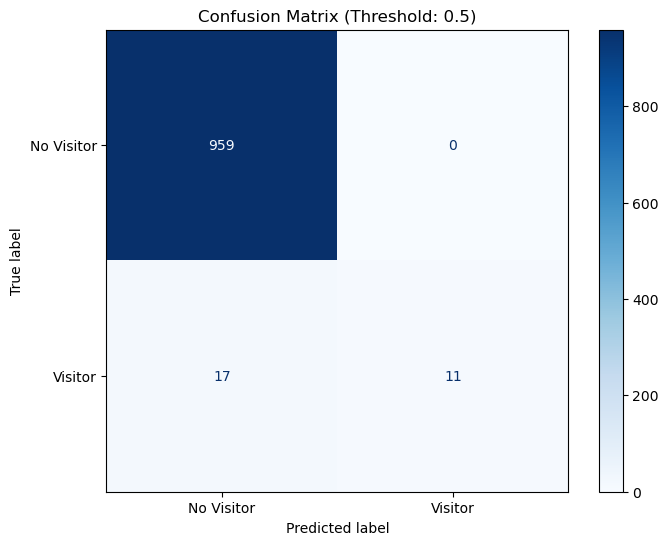

{'Threshold': 0.5,
 'Balanced Accuracy': 0.6964285714285714,
 'F1 Score': 0.5641025641025641}

In [112]:
score = Score(data_manager, trainer)
score.compute_score(data_manager, trainer, threshold=0.5)

## Final results
For 10% of the whole dataset, with the simple scale RGB HOG with oversampling (the model we found was the best during training), our balanced accuracy reached at 0.696 and our F1-score at 0.564.

### Hyperparameters
XGBClassifier:

    n_estimators=250,  

    max_depth=5,  

    learning_rate=0.03, 

    subsample=0.8,      

    colsample_bytree=0.8,  

    scale_pos_weight=10

    min_child_weight=5,

    gamma=0.5,  

    reg_alpha=0.1,

    reg_lambda=1.0,

    tree_method='hist',

    random_state=42,

    n_jobs=-1,

    enable_categorical=False,

    max_delta_step=1,

HOG:
    orientations = 12

    pixels_per_cell = (16, 16)

    cells_per_block = (1, 1)

    grayscale = False

    multiscale = False

Oversampling:

    Random Oversampling, ratio=0.1

# 4.5 Full Parameters Optimization (just as an example, do not run)

In [ ]:
# Pipeline Execution and Logging for Hyperparameter Tuning (do not use fully, it's a long one)
# Was used to generate the final optimized model and log results (on 10% of data for speed)

log_file = "hog_optimization_results.txt"
with open(log_file, "w") as f:
    f.write("=== HOG OPTIMIZATION LOG ===\n\n")

for i in range(0, 2): # 0 = Single-scale, 1 = Multi-scale
    for j in [True, False]: # Grayscale options
        trainer = Train(data_manager, grayscale=j, multiscale=bool(i))
        
        if i == 0:
            mode = "Single-Scale"
            trainer.tune_hog_settings()
        else:
            mode = "Multi-Scale"
            trainer.tune_multiscale_settings()
            
        # Tuning XGBoost phases
        for p in range(1, 5):
            trainer.tune_parameters(phase=p)
            
        # Training
        trainer.train(oversampling=None)

        # Summary data
        gs = trainer.model.get_params()
        hog_info = (f"Orient={trainer.best_h_orient}, Pix={trainer.best_h_pix}, Block={trainer.best_h_block}" 
                    if not i else f"S1={trainer.s1_config}, S2={trainer.s2_config}")
        
        # Logging results
        output = (
            f"\n{'='*40}\n"
            f"[Summary] Mode: {mode} | Grayscale: {j}\n"
            f"HOG Settings: {hog_info}\n"
            f"Final Model Params: {gs}\n"
        )
        print(output)
        
        with open(log_file, "a") as f:
            f.write(output)

        # Scoring
        score = Score(data_manager, trainer)
        for thr in [0.5, 0.45, 0.4]:
            res = score.compute_score(data_manager, trainer, threshold=thr)
            
            # On ajoute le score au fichier
            score_line = f"Threshold {thr} -> F1: {res['F1 Score']:.4f} | Balanced Acc: {res['Balanced Accuracy']:.4f}\n"
            with open(log_file, "a") as f:
                f.write(score_line)
                
        print("="*40)
        
        # Cleanup
        del trainer
        del score
        gc.collect()

# 5 - (Optional) Prepare submission for Codabench

***

In this section you should prepare a zip of the trained model (if your competition is a code submission competition) or zip of the predictions (if your competition is a result submission competition). 

***

In [ ]:
import os
import zipfile
import joblib
import pandas as pd

class Submission:
    def __init__(self, submission_dir, zip_file_name):
        self.submission_dir = submission_dir
        self.zip_file_name = zip_file_name
        # Create directory if it doesn't exist
        os.makedirs(self.submission_dir, exist_ok=True)

    def save_code(self, model):
        """
        Saves the trained model object to the submission directory.
        """
        model_path = os.path.join(self.submission_dir, "model.joblib")
        joblib.dump(model, model_path)
        print(f"Model saved at: {model_path}")

    def save_result(self, predictions):
        """
        Saves the prediction array as a CSV file.
        """
        result_path = os.path.join(self.submission_dir, "results.csv")
        # Convert to DataFrame for a clean CSV
        df = pd.DataFrame(predictions, columns=["prediction"])
        df.to_csv(result_path, index=False)
        print(f"Predictions saved at: {result_path}")
        
    def zip_submission(self):
        # Path to ZIP
        zip_path = os.path.join(self.submission_dir, self.zip_file_name)

        # Create ZIP containing the submission directory files
        with zipfile.ZipFile(zip_path, "w", compression=zipfile.ZIP_DEFLATED) as zf:
            for filename in os.listdir(self.submission_dir):
                file_path = os.path.join(self.submission_dir, filename)

                # Skip the zip file itself and hidden files
                if file_path == zip_path or filename.startswith('.'):
                    continue

                zf.write(file_path, arcname=filename)
        print(f"Submission ZIP saved at: {zip_path}")

In [ ]:
# Example usage
zip_file_name = f"Submission_{datetime.datetime.now().strftime('%y-%m-%d-%H-%M')}.zip"

submission = Submission (
    submission_dir="./submission",
    zip_file_name=zip_file_name
)
submission.save_code(trainer.model)
# or
X_test_flat = data_manager.X_test.reshape(len(data_manager.X_test), -1)
submission.save_result(trainer.model.predict(X_test_flat))

# Zip submission dir
submission.zip_submission()